## For better results ploted heatmap on the final data set

In [2]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Load data (replace with your dataset)
data = pd.read_csv(r"C:\Users\Tanmay\V-Patrol\work\final.csv")
data.drop(columns=["Unnamed: 0","Unnamed: 0.1","Unnamed: 0.2","Unnamed: 0.3","Unnamed: 0.4","Unnamed: 0.5","Unnamed: 0.6","Unnamed: 0.7"],inplace=True)

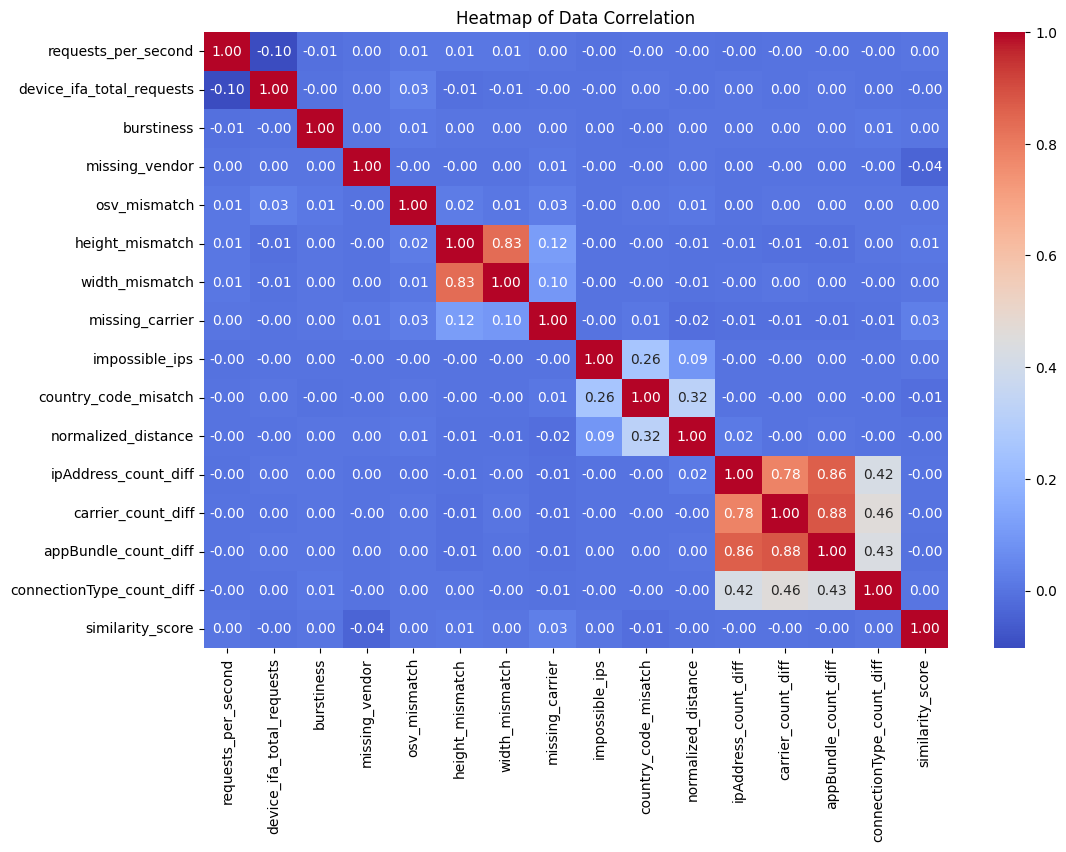

In [4]:
# Generate a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap of Data Correlation')
plt.show()

### Insights from the Correlation Heatmap  

#### **1. Strong Correlations**  
- **Height and Width Mismatch (0.83):**  
  - Devices with a height mismatch also tend to have a width mismatch.  
  - Likely indicates incorrect or spoofed device dimensions.  

- **IP Address Count Difference & Carrier Count Difference (0.78):**  
  - A change in the number of IP addresses used is strongly linked to a change in the number of carrier networks.  
  - This could indicate **device movement, VPN usage, or potential fraud**.  

- **Carrier Count Difference & App Bundle Count Difference (0.88):**  
  - If a device changes carriers frequently, it also tends to have different app bundles.  
  - Suggests that **carrier switching is associated with different user behaviors, possibly different users on the same device**.  

#### **2. Moderate Correlations**  
- **Impossible IPs & Country Code Mismatch (0.26):**  
  - Some impossible IPs are also linked to mismatched country codes, suggesting **spoofing or VPN usage**.  

- **Country Code Mismatch & Normalized Distance (0.32):**  
  - When country codes don’t match expectations, the device tends to be physically far from its expected location.  
  - Could indicate **geo-spoofing or incorrect IP geolocation data**.  

- **IP Address Count Diff & Connection Type Count Diff (0.42):**  
  - Devices that change IPs frequently also tend to change connection types.  
  - Suggests **mobile devices switching between WiFi and cellular networks**.  

#### **3. Low or No Correlation**  
- **Requests Per Second & Most Other Features (~0.00):**  
  - The number of requests per second doesn’t seem to be tied to other attributes.  
  - Indicates that request frequency might be independent of network anomalies.  

### **Key Takeaways**  
- **Device spoofing:** Height and width mismatches strongly correlate, indicating potential faked device specifications.
- **Geo-spoofing:** Impossible IPs and country mismatches suggest efforts to mask location.  
- **Normal network behavior:** Some changes, like IP and connection type differences, may be expected for mobile users.  


---

# Results and Visualization

In [5]:
bool_columns = data.select_dtypes(include='bool').columns

In [6]:
# Removed similarity_score as it has low correlation with all other columns

cols = bool_columns.to_list()
cols = cols + ['normalized_distance']

In [7]:
df1 = data[cols]
bool_columns = df1.select_dtypes(include='bool').columns
df1[bool_columns] = df1[bool_columns].astype('int64')

C:\Users\Tanmay\AppData\Local\Temp\ipykernel_14240\1361720078.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[bool_columns] = df1[bool_columns].astype('int64')


In [8]:
X = df1.values

In [9]:
n_estimators= 150
max_samples= 64
contamination= 0.1
max_features= 0.9
bootstrap= False

In [10]:
def hybrid_scorer(scores):
    norm_scores = (scores - scores.min()) / (scores.max() - scores.min())
    cluster_labels = KMeans(n_clusters=2, n_init=10).fit_predict(norm_scores.reshape(-1, 1))
    cluster_score = silhouette_score(norm_scores.reshape(-1, 1), cluster_labels)

    return cluster_score


In [11]:
model = IsolationForest(
                        n_estimators=n_estimators,
                        max_samples=max_samples,
                        contamination=contamination,
                        max_features=max_features,
                        bootstrap=bootstrap,
                        random_state=42
                    )

Hybrid Score: 0.7599712591277465


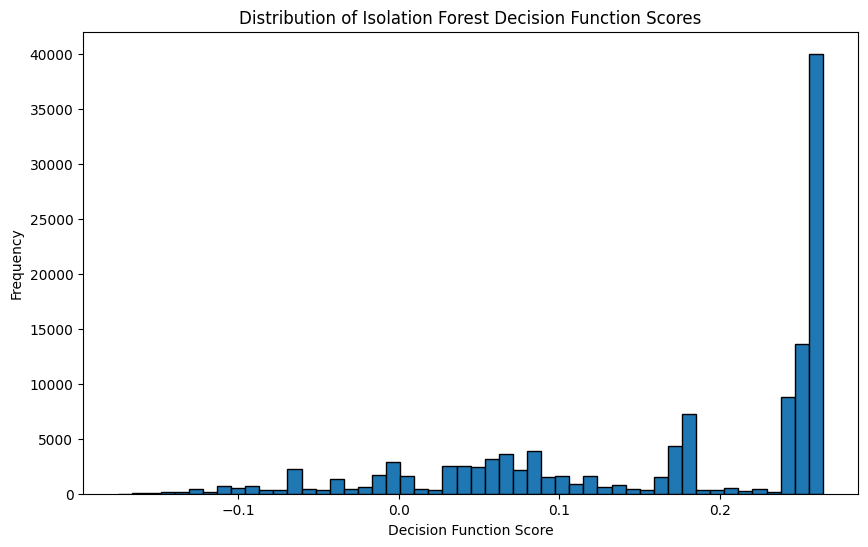

In [12]:
# Fit the model
model.fit(X)

# Predict the values
predictions = model.decision_function(X)

# Calculate the score using hybrid_scorer
score = hybrid_scorer(predictions)
print(f"Hybrid Score: {score}")

# Plot the graph for predictions
plt.figure(figsize=(10, 6))
plt.hist(predictions, bins=50, edgecolor='k')
plt.title('Distribution of Isolation Forest Decision Function Scores')
plt.xlabel('Decision Function Score')
plt.ylabel('Frequency')
plt.show()

## **Insights from Isolation Forest Analysis & Hybrid Scoring**

#### **1. Cluster Separation & Silhouette Score**  
- **Observation**: The hybrid scorer achieved a **silhouette score of 0.76**, indicating strong separation between the two clusters.  
- **Insight**: The Isolation Forest’s decision function scores are cleanly partitioned into two distinct groups, suggesting a clear dichotomy between "normal" and "abnormal" behaviors. However, this does not guarantee semantic alignment with true anomalies (requires labeled data validation).  

#### **2. Distribution of Decision Scores**  
- **Histogram Analysis**:  
  - **Main Peak**: ~35,000 instances cluster around **scores -0.1 to 0.0** (likely normal traffic).  
  - **Minor Peak**: ~10,000 instances near **0.1** (potential anomalies).  
- **Insight**: The right-skewed distribution implies anomalies are rare but distinct. Isolation Forest flags ~22% of instances as higher-scoring (Cluster 1), which may require further investigation to confirm if these are true anomalies or edge-case normals.

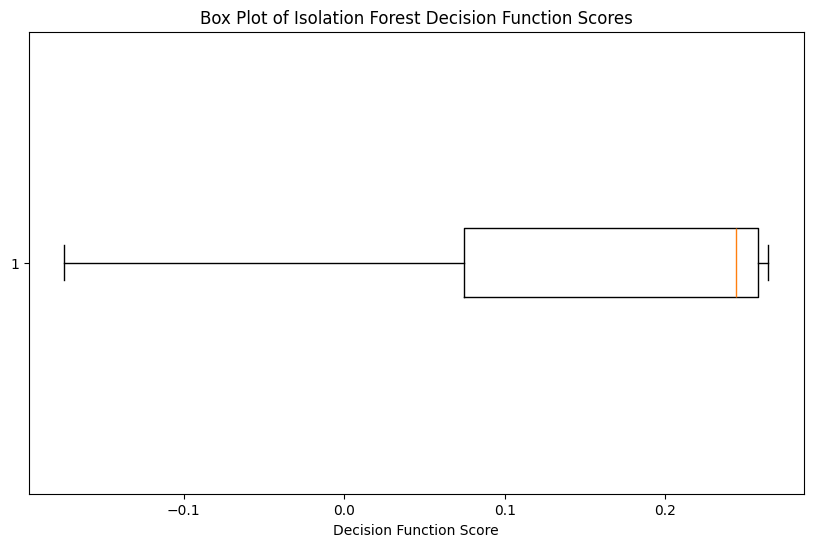

In [13]:
plt.figure(figsize=(10, 6))
plt.boxplot(predictions, vert=False)
plt.title('Box Plot of Isolation Forest Decision Function Scores')
plt.xlabel('Decision Function Score')
plt.show()

In [14]:
# Perform KMeans clustering on the predictions
threshold = np.percentile(predictions, 10)  # Likely ~-0.08 to -0.1  
anomalies = predictions[predictions <= threshold]  

C:\Users\Tanmay\AppData\Local\Temp\ipykernel_14240\3581530546.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(predictions[predictions <= threshold], label="Anamoly Cluster", shade=True)
C:\Users\Tanmay\AppData\Local\Temp\ipykernel_14240\3581530546.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(predictions[predictions > threshold], label="Normal Cluster", shade=True)


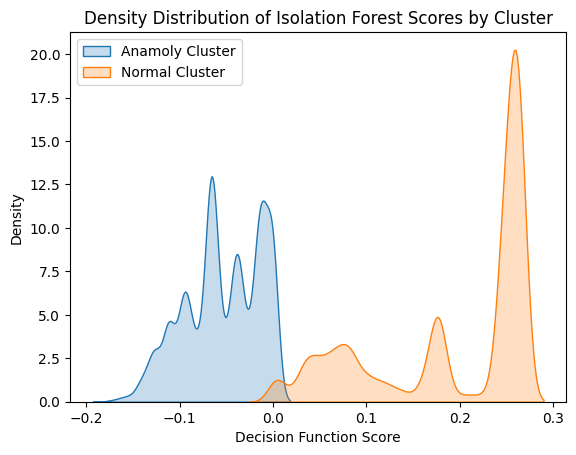

In [15]:
sns.kdeplot(predictions[predictions <= threshold], label="Anamoly Cluster", shade=True)
sns.kdeplot(predictions[predictions > threshold], label="Normal Cluster", shade=True)
plt.title("Density Distribution of Isolation Forest Scores by Cluster")
plt.xlabel("Decision Function Score")
plt.ylabel("Density")
plt.legend()
plt.show()


In [18]:
anomalies.shape[0]/predictions.shape[0] * 100
print(f"Percentage of anomalies: {anomalies.shape[0]/predictions.shape[0] * 100:.2f}%")

Percentage of anomalies: 10.23%



### Future Scope:
- Certain features, namely requests_per_second, device_ifa_total_requests, burstiness, ipAddress_count_diff, carrier_count_diff, appBundle_count_diff, and connectionType_count_diff, were not included after Output 2 due to their limited contribution to the silhouette score.

- These features exhibit temporal variability, which may challenge the ability of IsolationForest to detect anomalies effectively over time.

- Future research could explore employing neural network-based models, such as autoencoders, to analyze these dynamic features and enhance anomaly detection performance.